# 1. Data Preprocessing for Federated Learning

**Project:** IoT Network Attack Detection using Federated Learning  
**Dataset:** CICIoT2023 (~12GB, 169 CSV files)  
**Author:** Nguyen Duc Thang

---

## 📋 Objectives

1. Load the CICIoT2023 dataset (169 CSV files) using chunking
2. Clean data (remove nulls, duplicates)
3. Encode 34 attack classes to numeric labels (0-33)
4. Normalize features using MinMaxScaler
5. Partition data for 5 clients (Non-IID distribution)
6. Save preprocessed data for training

---

## 🎯 Expected Outputs

- `../Output/data/client_0_data.npz` ... `client_4_data.npz`
- `../Output/data/test_data.npz`
- `../Output/models/scaler.pkl`
- `../Output/models/label_encoder.pkl`
- `../Output/models/labels.json`


## 1. Setup and Imports


In [1]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path

# Import our utility modules
from utils import data_utils
from utils import fl_utils_pytorch
from utils.includes import X_columns, y_column, dict_34_classes

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All imports successful!")
print(f"   Number of features: {len(X_columns)}")
print(f"   Label column: {y_column}")
print(f"   Number of attack classes: {len(dict_34_classes)}")

✅ All imports successful!
   Number of features: 46
   Label column: label
   Number of attack classes: 34


## 2. Load Configuration


In [2]:
# Load training configuration
config_path = 'configs/training_config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("📄 Configuration loaded:")
print(f"   Number of clients: {config['num_clients']}")
print(f"   Test split ratio: {config['data']['test_split_ratio']}")
print(f"   Chunk size: {config['data']['chunk_size']}")
print(f"   Partition strategy: {config['data']['partition_strategy']}")
print(f"   Use sample data: {config['experimental']['use_sample_data']}")

if config['experimental']['use_sample_data']:
    print(f"   ⚠️  Using {config['experimental']['sample_fraction']*100}% of data for testing")

📄 Configuration loaded:
   Number of clients: 5
   Test split ratio: 0.2
   Chunk size: 50000
   Partition strategy: non_iid
   Use sample data: False


## 3. Load or Preprocess Dataset

This section implements a caching strategy:

1. **Check cache**: If `train_dataset.csv` and `test_dataset.csv` exist in `../Output/preprocessed/`, load them directly
2. **Otherwise**: Run full preprocessing pipeline:
   - Load all CSV files from `../DataTests`
   - Merge into single DataFrame
   - **Shuffle** (CRITICAL for unbiased training)
   - Split into train (95%) and test (5%)
   - Save to `../Output/preprocessed/`

**Why shuffling is critical**: Raw data files may be ordered by time or attack category. Without shuffling, the train/test split would be biased.


In [3]:
import glob
from sklearn.model_selection import train_test_split
from utils.includes import y_column  # Import y_column for stratified split

# ============================================================================
# CONFIGURATION
# ============================================================================
data_dir = '../DataTests'  # Folder containing raw CSV files
output_dir = '../Output/preprocessed'  # Output directory for train/test files
os.makedirs(output_dir, exist_ok=True)

train_file = os.path.join(output_dir, 'train_dataset.csv')
test_file = os.path.join(output_dir, 'test_dataset.csv')

# Use test split ratio from config (20% for test, 80% for train)
test_size = config['data']['test_split_ratio']  # From config: 0.2 (20%)
random_seed = config['random_seed']  # Use same seed as config

print(f"📋 Split configuration:")
print(f"   Test size: {test_size*100:.0f}%")
print(f"   Train size: {(1-test_size)*100:.0f}%")
print(f"   Random seed: {random_seed}")

# ============================================================================
# CHECK CACHE: Load existing files if available
# ============================================================================
if os.path.exists(train_file) and os.path.exists(test_file):
    print("="*80)
    print("CACHE HIT: Loading preprocessed datasets from disk")
    print("="*80)
    print(f"\n📂 Loading from cache:")
    print(f"   - Train: {train_file}")
    print(f"   - Test: {test_file}")
    
    df_train = pd.read_csv(train_file, low_memory=False)
    df_test = pd.read_csv(test_file, low_memory=False)
    
    print(f"\n✅ Loaded from cache successfully!")
    print(f"   Train shape: {df_train.shape}")
    print(f"   Test shape: {df_test.shape}")
    print(f"   Total rows: {len(df_train) + len(df_test):,}")
    print(f"\n💡 To reprocess from scratch, delete files in: {output_dir}")
    print("="*80)

else:
    # ========================================================================
    # CACHE MISS: Run full preprocessing pipeline
    # ========================================================================
    print("="*80)
    print("CACHE MISS: Running full preprocessing pipeline")
    print("="*80)
    
    # ------------------------------------------------------------------------
    # STEP 1: LOAD ALL CSV FILES
    # ------------------------------------------------------------------------
    print("\n" + "="*80)
    print("STEP 1: LOADING ALL FILES FROM DATASETS FOLDER")
    print("="*80)
    
    csv_pattern = os.path.join(data_dir, '*.csv')
    csv_files = sorted(glob.glob(csv_pattern))
    
    if len(csv_files) == 0:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    
    print(f"\n📂 Found {len(csv_files)} CSV files in '{data_dir}'")
    print(f"   First file: {os.path.basename(csv_files[0])}")
    print(f"   Last file: {os.path.basename(csv_files[-1])}")
    
    # Load all files
    dataframes = []
    total_rows = 0
    
    for i, file_path in enumerate(csv_files):
        try:
            df_file = pd.read_csv(file_path, low_memory=False)
            rows = len(df_file)
            total_rows += rows
            dataframes.append(df_file)
            
            if (i + 1) % 20 == 0 or (i + 1) == len(csv_files):
                print(f"   [{i+1}/{len(csv_files)}] Loaded {os.path.basename(file_path)}: {rows:,} rows")
        except Exception as e:
            print(f"   ⚠️  Error loading {os.path.basename(file_path)}: {e}")
            continue
    
    print(f"\n✅ Loaded {len(dataframes)} files with {total_rows:,} total rows")
    
    # ------------------------------------------------------------------------
    # STEP 2: MERGE ALL DATAFRAMES
    # ------------------------------------------------------------------------
    print("\n" + "="*80)
    print("STEP 2: MERGING ALL FILES INTO ONE DATAFRAME")
    print("="*80)
    
    df_merged = pd.concat(dataframes, ignore_index=True)
    
    print(f"\n✅ Merged DataFrame created!")
    print(f"   Shape: {df_merged.shape}")
    print(f"   Memory usage: {df_merged.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Free memory
    del dataframes
    
    # ------------------------------------------------------------------------
    # STEP 3: SHUFFLE DATA (CRITICAL STEP!)
    # ------------------------------------------------------------------------
    print("\n" + "="*80)
    print("STEP 3: SHUFFLING DATA (Ensuring Random Distribution)")
    print("="*80)
    
    print("\n🔀 Shuffling all rows to ensure unbiased distribution...")
    df_shuffled = df_merged.sample(frac=1.0, random_state=random_seed).reset_index(drop=True)
    
    print(f"✅ Data shuffled successfully!")
    print(f"   Shape after shuffle: {df_shuffled.shape}")
    print(f"\n📝 Note: Shuffling is critical because:")
    print(f"   - Data might be ordered by time or category across files")
    print(f"   - Without shuffling, train/test split would be biased")
    print(f"   - Shuffling ensures each split represents the whole population")
    
    # Free memory
    del df_merged
    
    # ------------------------------------------------------------------------
    # STEP 4: SPLIT INTO TRAIN AND TEST SETS (STRATIFIED)
    # ------------------------------------------------------------------------
    print("\n" + "="*80)
    print("STEP 4: SPLITTING INTO TRAIN AND TEST SETS (STRATIFIED)")
    print("="*80)
    
    print(f"\n📊 Splitting data: {test_size*100}% test, {(1-test_size)*100}% train")
    print(f"   Using STRATIFIED split to ensure all labels appear in both sets")
    
    # Use stratified split to ensure all labels appear in both train and test
    # This is critical for labels with few samples (like label 0)
    try:
        df_train, df_test = train_test_split(
            df_shuffled,
            test_size=test_size,
            random_state=random_seed,
            stratify=df_shuffled[y_column]  # Stratify by label column
        )
        print(f"   ✅ Stratified split successful!")
    except ValueError as e:
        # If stratification fails (e.g., a label has < 2 samples), use non-stratified
        print(f"   ⚠️  Stratified split failed: {e}")
        print(f"   → Falling back to non-stratified split")
        df_train, df_test = train_test_split(
            df_shuffled,
            test_size=test_size,
            random_state=random_seed
        )
    
    print(f"✅ Data split completed!")
    print(f"   Train set: {len(df_train):,} rows ({len(df_train)/len(df_shuffled)*100:.2f}%)")
    print(f"   Test set: {len(df_test):,} rows ({len(df_test)/len(df_shuffled)*100:.2f}%)")
    
    # Verify that all labels appear in both sets
    train_labels = set(df_train[y_column].unique())
    test_labels = set(df_test[y_column].unique())
    all_labels = set(df_shuffled[y_column].unique())
    
    if train_labels == all_labels and test_labels == all_labels:
        print(f"   ✅ All {len(all_labels)} labels present in both train and test sets")
    else:
        missing_in_train = sorted(all_labels - train_labels)
        missing_in_test = sorted(all_labels - test_labels)
        if missing_in_train:
            print(f"   ⚠️  Warning: {len(missing_in_train)} labels missing in train: {missing_in_train}")
        if missing_in_test:
            print(f"   ⚠️  Warning: {len(missing_in_test)} labels missing in test: {missing_in_test}")
    
    # ------------------------------------------------------------------------
    # STEP 5: EXPORT TO CSV FILES
    # ------------------------------------------------------------------------
    print("\n" + "="*80)
    print("STEP 5: EXPORTING TO CSV FILES")
    print("="*80)
    
    print(f"\n💾 Saving train set to: {train_file}")
    df_train.to_csv(train_file, index=False)
    train_size_mb = os.path.getsize(train_file) / 1024**2
    print(f"   ✅ Saved! Size: {train_size_mb:.2f} MB")
    
    print(f"\n💾 Saving test set to: {test_file}")
    df_test.to_csv(test_file, index=False)
    test_size_mb = os.path.getsize(test_file) / 1024**2
    print(f"   ✅ Saved! Size: {test_size_mb:.2f} MB")
    
    # ------------------------------------------------------------------------
    # SUMMARY
    # ------------------------------------------------------------------------
    print("\n" + "="*80)
    print("PREPROCESSING SUMMARY")
    print("="*80)
    print(f"📊 Original data: {total_rows:,} rows from {len(csv_files)} files")
    print(f"📊 After merge & shuffle: {df_shuffled.shape[0]:,} rows, {df_shuffled.shape[1]} columns")
    print(f"📊 Train set: {len(df_train):,} rows → {train_file}")
    print(f"📊 Test set: {len(df_test):,} rows → {test_file}")
    print(f"\n✅ Preprocessing completed successfully!")
    print(f"💡 Next run will load from cache (delete files to reprocess)")
    print("="*80)
    
    # Free memory
    del df_shuffled

# Display sample data
print("\n📋 Sample from Train set (first 3 rows):")
display(df_train.head(3))
print("\n📋 Sample from Test set (first 3 rows):")
display(df_test.head(3))


📋 Split configuration:
   Test size: 20%
   Train size: 80%
   Random seed: 42
CACHE MISS: Running full preprocessing pipeline

STEP 1: LOADING ALL FILES FROM DATASETS FOLDER

📂 Found 11 CSV files in '../DataTests'
   First file: part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
   Last file: part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
   [11/11] Loaded part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv: 251,392 rows

✅ Loaded 11 files with 2,618,348 total rows

STEP 2: MERGING ALL FILES INTO ONE DATAFRAME

✅ Merged DataFrame created!
   Shape: (2618348, 47)
   Memory usage: 1099.76 MB

STEP 3: SHUFFLING DATA (Ensuring Random Distribution)

🔀 Shuffling all rows to ensure unbiased distribution...
✅ Data shuffled successfully!
   Shape after shuffle: (2618348, 47)

📝 Note: Shuffling is critical because:
   - Data might be ordered by time or category across files
   - Without shuffling, train/test split would be biased
   - Shuffling ensures each split represents

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
2041133,0.000000,0.0,1.0,64.0,153.325021,153.325021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,441.0,42.0,42.0,42.0,0.0,42.0,8.312466e+07,9.5,9.165151,0.0,0.0,0.0,141.55,DDoS-ICMP_Flood
1507126,0.000000,0.0,1.0,64.0,31.609453,31.609453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,441.0,42.0,42.0,42.0,0.0,42.0,8.312402e+07,9.5,9.165151,0.0,0.0,0.0,141.55,DDoS-ICMP_Flood
1466681,0.049156,23615.0,17.0,64.0,9614.632389,9614.632389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,525.0,50.0,50.0,50.0,0.0,50.0,8.310227e+07,9.5,10.000000,0.0,0.0,0.0,141.55,DDoS-UDP_Flood



📋 Sample from Test set (first 3 rows):


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
190827,0.0,54.0,6.0,64.0,5.439395,5.439395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.0,54.0,54.0,54.0,0.0,54.0,8.306399e+07,9.5,10.392305,0.0,0.0,0.0,141.55,DDoS-TCP_Flood
2039758,0.0,0.0,1.0,64.0,0.399682,0.399682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,441.0,42.0,42.0,42.0,0.0,42.0,8.312771e+07,9.5,9.165151,0.0,0.0,0.0,141.55,DDoS-ICMP_Flood
73096,0.0,54.0,6.0,64.0,699050.666667,699050.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.0,54.0,54.0,54.0,0.0,54.0,8.336567e+07,9.5,10.392305,0.0,0.0,0.0,141.55,DDoS-SynonymousIP_Flood


In [4]:

# Display data types
print("\n📋 Data types:")
print(df_train.dtypes.value_counts())

# Display basic statistics
print("\n📈 Basic statistics:")
display(df_train.describe())


📋 Data types:
float64    46
object      1
Name: count, dtype: int64

📈 Basic statistics:


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
count,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2094678.0,2094678.0,2.094678e+06,2094678.0,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06,2.094678e+06
mean,5.616967e+00,7.751724e+04,9.061673e+00,6.636545e+01,9.030879e+03,9.030879e+03,3.289012e-06,8.650494e-02,2.068051e-01,9.042488e-02,8.794860e-02,1.237742e-01,1.432201e-06,4.774003e-07,9.045640e-02,3.296215e-01,9.889252e-02,6.341777e+00,3.909821e+01,4.835063e-02,5.525050e-02,1.355817e-04,0.0,0.0,4.583043e-05,0.0,5.738605e-01,2.121476e-01,1.432201e-06,6.349425e-05,1.636753e-01,9.998907e-01,9.998907e-01,1.309920e+03,9.166344e+01,1.823847e+02,1.248129e+02,3.345574e+01,1.248142e+02,8.319356e+07,9.498952e+00,1.312613e+01,4.728013e+01,3.103803e+04,9.654839e-02,1.415246e+02
std,2.673177e+02,4.652188e+05,8.933885e+00,1.409828e+01,9.959123e+04,9.959123e+04,2.118250e-03,2.811083e-01,4.050146e-01,2.867896e-01,2.832202e-01,3.293238e-01,1.196745e-03,6.909416e-04,2.862958e-01,6.628040e-01,3.191739e-01,7.312611e+01,3.296507e+02,2.145061e-01,2.284686e-01,1.164317e-02,0.0,0.0,6.769664e-03,0.0,4.945147e-01,4.088289e-01,1.196745e-03,7.968077e-03,3.699807e-01,1.045528e-02,1.045528e-02,2.621146e+03,1.401994e+02,5.267405e+02,2.415793e+02,1.610803e+02,2.423849e+02,1.707595e+07,8.206082e-01,8.638185e+00,2.278253e+02,3.400634e+05,2.331194e-01,2.110471e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,0.000000e+00,4.200000e+01,0.000000e+00,1.000000e+00,9.165151e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,5.400000e+01,6.000000e+00,6.400000e+01,2.099664e+00,2.099664e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,5.250000e+02,5.000000e+01,5.000000e+01,5.000000e+01,0.000000e+00,5.000000e+01,8.307157e+07,9.500000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02
50%,0.000000e+00,5.400000e+01,6.000000e+00,6.400000e+01,1.578934e+01,1.578934e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,5.670000e+02,5.400000e+01,5.400000e+01,5.400000e+01,0.000000e+00,5.400000e+01,8.312452e+07,9.500000e+00,1.039230e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02
75%,1.047171e-01,2.999700e+02,1.438000e+01,6.400000e+01,1.172738e+02,1.172738e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00

### 3.2 Check Label Distribution


📊 Label distribution (34 unique labels):
label
DDoS-ICMP_Flood            323034
DDoS-UDP_Flood             242806
DDoS-TCP_Flood             202511
DDoS-PSHACK_Flood          184101
DDoS-SYN_Flood             182237
DDoS-RSTFINFlood           181338
DDoS-SynonymousIP_Flood    160956
DoS-UDP_Flood              149283
DoS-TCP_Flood              119644
DoS-SYN_Flood               90263
BenignTraffic               49481
Mirai-greeth_flood          44150
Mirai-udpplain              40052
Mirai-greip_flood           33715
DDoS-ICMP_Fragmentation     20246
MITM-ArpSpoofing            13806
DDoS-UDP_Fragmentation      12953
DDoS-ACK_Fragmentation      12800
DNS_Spoofing                 8114
Recon-HostDiscovery          5994
Recon-OSScan                 4494
Recon-PortScan               3690
DoS-HTTP_Flood               3259
VulnerabilityScan            1673
DDoS-HTTP_Flood              1279
DDoS-SlowLoris               1042
DictionaryBruteForce          583
BrowserHijacking              258
S

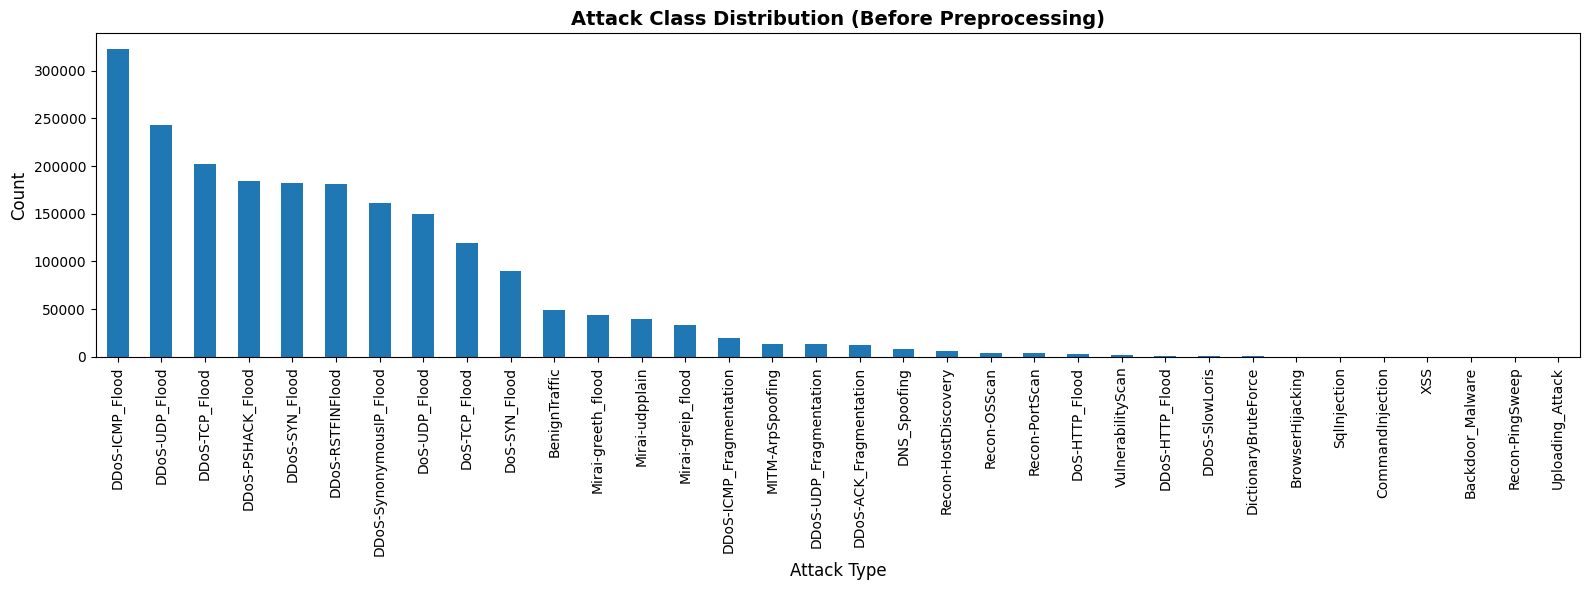


⚖️  Class imbalance ratio: 5047.41x
   ⚠️  Significant class imbalance detected!
   Consider using class weights during training.


In [5]:
# Check label distribution
label_counts = df_train[y_column].value_counts()

print(f"📊 Label distribution ({len(label_counts)} unique labels):")
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(16, 6))
label_counts.plot(kind='bar')
plt.title('Attack Class Distribution (Before Preprocessing)', fontsize=14, fontweight='bold')
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Check for class imbalance
max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count
print(f"\n⚖️  Class imbalance ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 10:
    print("   ⚠️  Significant class imbalance detected!")
    print("   Consider using class weights during training.")

## 4. Clean Data

Remove missing values and duplicates.


In [6]:
# Clean data for BOTH train and test sets
print("="*80)
print("CLEANING TRAIN AND TEST SETS")
print("="*80)

# Clean train data
df_train_clean = data_utils.clean_data(df_train)
print(f"\n✅ Train data cleaned!")
print(f"   Original rows: {len(df_train):,}")
print(f"   Cleaned rows: {len(df_train_clean):,}")
print(f"   Rows removed: {len(df_train) - len(df_train_clean):,} ({(len(df_train) - len(df_train_clean))/len(df_train)*100:.2f}%)")

# Clean test data
df_test_clean = data_utils.clean_data(df_test)
print(f"\n✅ Test data cleaned!")
print(f"   Original rows: {len(df_test):,}")
print(f"   Cleaned rows: {len(df_test_clean):,}")
print(f"   Rows removed: {len(df_test) - len(df_test_clean):,} ({(len(df_test) - len(df_test_clean))/len(df_test)*100:.2f}%)")

# Update dataframes
df_train = df_train_clean
df_test = df_test_clean
del df_train_clean, df_test_clean  # Free memory

print("="*80)

CLEANING TRAIN AND TEST SETS

🧹 Cleaning data...
   ✓ No missing values
   ✓ No duplicates
   Final rows: 2,094,678

✅ Train data cleaned!
   Original rows: 2,094,678
   Cleaned rows: 2,094,678
   Rows removed: 0 (0.00%)

🧹 Cleaning data...
   ✓ No missing values
   ✓ No duplicates
   Final rows: 523,670

✅ Test data cleaned!
   Original rows: 523,670
   Cleaned rows: 523,670
   Rows removed: 0 (0.00%)


## 4. GSA Feature Selection (Chọn Lọc Đặc Trưng)

Sử dụng **Gravitational Search Algorithm (GSA)** để tự động chọn các đặc trưng quan trọng nhất.

**Mục tiêu**:

- Chọn 20 đặc trưng tốt nhất từ 46 đặc trưng gốc
- Phương pháp: GSA với fitness function sử dụng Random Forest
- Thời gian: ~30-60 phút với 20% dữ liệu mẫu

**Lợi ích**:

- Loại bỏ nhiễu và redundancy
- Giảm overfitting
- Tăng độ chính xác model


In [7]:
# ============================================================================
# GSA FEATURE SELECTION (ĐÃ TỐI ƯU CHO PROXY MODEL KNN)
# ============================================================================

from utils.gsa_algorithm import GravitationalSearchAlgorithm
# Import data_utils module
from utils import data_utils
from sklearn.preprocessing import MinMaxScaler  # Import thêm để chuẩn hóa cho KNN
import os

print("="*80)
print("GIAI ĐOẠN 4: GSA FEATURE SELECTION")
print("="*80)

gsa_config = config['gsa']

if gsa_config['enabled']:
    print(f"\n🧬 Chạy GSA để chọn {gsa_config['num_features_to_select']} đặc trưng...")
    
    # --- 1. LẤY MẪU DỮ LIỆU (SAMPLING) ---
    if gsa_config['use_sample']:
        sample_size = int(len(df_train) * gsa_config['sample_fraction'])
        df_sample = df_train.sample(n=sample_size, random_state=gsa_config['random_seed'])
        print(f"   Sử dụng {sample_size:,} mẫu ({gsa_config['sample_fraction']*100}%) cho GSA")
    else:
        df_sample = df_train
        print(f"   Sử dụng toàn bộ dataset ({len(df_train):,} mẫu)")
    
    # --- 2. CHUẨN BỊ VÀ CHUẨN HÓA DỮ LIỆU (QUAN TRỌNG CHO KNN) ---
    print("   -> Đang chuẩn hóa tạm thời dữ liệu mẫu (MinMax) để tối ưu cho KNN...")
    
    # Tạo scaler tạm thời
    scaler_temp = MinMaxScaler()
    X_gsa_raw = df_sample[X_columns].values
    
    # Transform dữ liệu về đoạn [0, 1] để KNN tính khoảng cách chính xác
    X_gsa = scaler_temp.fit_transform(X_gsa_raw)
    y_gsa = df_sample[y_column].values
    
    # --- 3. CẤU HÌNH VÀ CHẠY GSA ---
    print(f"\n⚙️  Cấu hình GSA:")
    print(f"   Kích thước population: {gsa_config['population_size']}")
    print(f"   Số vòng lặp tối đa: {gsa_config['max_iterations']}")
    print(f"   Số đặc trưng mục tiêu: {gsa_config['num_features_to_select']}")
    print(f"   Hằng số hấp dẫn: {gsa_config['gravitational_constant']}")
    print(f"   Alpha (tốc độ giảm G): {gsa_config['alpha']}")
    
    # Kiểm tra nhanh xem config đã nhận giá trị tối ưu chưa
    if gsa_config['sample_fraction'] > 0.1:
        print("\n⚠️ CẢNH BÁO: Sample fraction > 10%. Quá trình có thể bị chậm.")
    
    # Khởi tạo GSA
    gsa = GravitationalSearchAlgorithm(
        num_features=len(X_columns),
        target_num_features=gsa_config['num_features_to_select'],
        population_size=gsa_config['population_size'],
        max_iterations=gsa_config['max_iterations'],
        gravitational_constant=gsa_config['gravitational_constant'],
        alpha=gsa_config['alpha'],
        random_seed=gsa_config['random_seed']
    )
    
    print(f"\n🚀 Bắt đầu tối ưu hóa GSA (với Proxy Model KNN)...")
    print(f"   Quá trình này dự kiến mất vài phút (nếu sample=5%). Vui lòng kiên nhẫn.\n")
    
    # Chạy GSA
    best_features_mask = gsa.run(X_gsa, y_gsa, verbose=True)
    
    # Lấy tên các đặc trưng được chọn
    selected_features = [X_columns[i] for i in range(len(X_columns)) if best_features_mask[i] == 1]
    
    # --- 4. KẾT QUẢ VÀ LƯU TRỮ ---
    print(f"\n" + "="*80)
    print(f"✅ GSA HOÀN THÀNH!")
    print(f"="*80)
    print(f"Đã chọn {len(selected_features)} đặc trưng (từ {len(X_columns)} đặc trưng gốc)")
    print(f"Fitness tốt nhất (KNN Accuracy): {gsa.best_fitness:.4f}")
    print(f"\n📋 Các đặc trưng được chọn:")
    for i, feat in enumerate(selected_features, 1):
        print(f"   {i:2d}. {feat}")
    
    # Lưu kết quả GSA
    os.makedirs(gsa_config['output_dir'], exist_ok=True)
    
    results_path = os.path.join(gsa_config['output_dir'], gsa_config['selected_features_json'])
    gsa.save_results(X_columns, results_path)
    
    convergence_path = os.path.join(gsa_config['output_dir'], gsa_config['convergence_plot'])
    gsa.plot_convergence(convergence_path)
    
    print(f"\n💾 Kết quả đã lưu:")
    print(f"   - Danh sách đặc trưng: {results_path}")
    print(f"   - Biểu đồ hội tụ: {convergence_path}")
    
    # Lọc dataset TRAIN chỉ giữ lại các đặc trưng được chọn
    df_train_filtered = data_utils.filter_features_by_names(df_train, selected_features, y_column)
    
    # Lọc dataset TEST với cùng các đặc trưng
    df_test_filtered = data_utils.filter_features_by_names(df_test, selected_features, y_column)
    
    print(f"✅ Train dataset đã được lọc còn {len(selected_features)} đặc trưng")
    print(f"✅ Test dataset đã được lọc còn {len(selected_features)} đặc trưng")
    
    # Cập nhật X_columns cho phần còn lại của notebook
    X_columns_original = X_columns.copy()  # Backup
    X_columns = selected_features  # Sử dụng features đã chọn
    
    # Cập nhật dataframes
    df_train = df_train_filtered
    df_test = df_test_filtered
    
else:
    print("\n⚠️  GSA bị tắt trong config - sử dụng tất cả 46 đặc trưng")
    X_columns_original = X_columns.copy()

print(f"\n📊 Tiếp tục với {len(X_columns)} đặc trưng cho preprocessing")

GIAI ĐOẠN 4: GSA FEATURE SELECTION

🧬 Chạy GSA để chọn 20 đặc trưng...
   Sử dụng 104,733 mẫu (5.0%) cho GSA
   -> Đang chuẩn hóa tạm thời dữ liệu mẫu (MinMax) để tối ưu cho KNN...


INFO:utils.gsa_algorithm:GSA initialized: 46 features → 20 target
INFO:utils.gsa_algorithm:Starting GSA with 104733 samples, 46 features



⚙️  Cấu hình GSA:
   Kích thước population: 15
   Số vòng lặp tối đa: 30
   Số đặc trưng mục tiêu: 20
   Hằng số hấp dẫn: 100.0
   Alpha (tốc độ giảm G): 20.0

🚀 Bắt đầu tối ưu hóa GSA (với Proxy Model KNN)...
   Quá trình này dự kiến mất vài phút (nếu sample=5%). Vui lòng kiên nhẫn.



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
INFO:utils.gsa_algorithm:Iteration 0/30: Best Fitness=0.9594, Avg Fitness=0.8578, Features=22
INFO:utils.gsa_algorithm:Iteration 5/30: Best Fitness=0.9594, Avg Fitness=0.8718, Features=22
INFO:utils.gsa_algorithm:Iteration 10/30: Best Fitness=0.9594, Avg Fitness=0.8578, Features=22
INFO:utils.gsa_algorithm:Iteration 15/30: Best Fitness=0.9594, Avg Fitness=0.8578, Features=22
INFO:utils.gsa_algorithm:Iteration 20/30: Best Fitness=0


✅ GSA HOÀN THÀNH!
Đã chọn 22 đặc trưng (từ 46 đặc trưng gốc)
Fitness tốt nhất (KNN Accuracy): 0.9594

📋 Các đặc trưng được chọn:
    1. Srate
    2. Drate
    3. fin_flag_number
    4. syn_flag_number
    5. psh_flag_number
    6. cwr_flag_number
    7. ack_count
    8. fin_count
    9. urg_count
   10. rst_count
   11. HTTP
   12. IRC
   13. ICMP
   14. IPv
   15. LLC
   16. Tot sum
   17. AVG
   18. Tot size
   19. IAT
   20. Number
   21. Magnitue
   22. Covariance


INFO:utils.gsa_algorithm:Convergence plot saved to ../Output/gsa_results/gsa_convergence.png



💾 Kết quả đã lưu:
   - Danh sách đặc trưng: ../Output/gsa_results/selected_features.json
   - Biểu đồ hội tụ: ../Output/gsa_results/gsa_convergence.png
✅ Filtered features: 22 features retained
✅ Filtered features: 22 features retained
✅ Train dataset đã được lọc còn 22 đặc trưng
✅ Test dataset đã được lọc còn 22 đặc trưng

📊 Tiếp tục với 22 đặc trưng cho preprocessing


📈 Biểu đồ hội tụ GSA:
   (Cho thấy fitness tăng dần qua các vòng lặp)



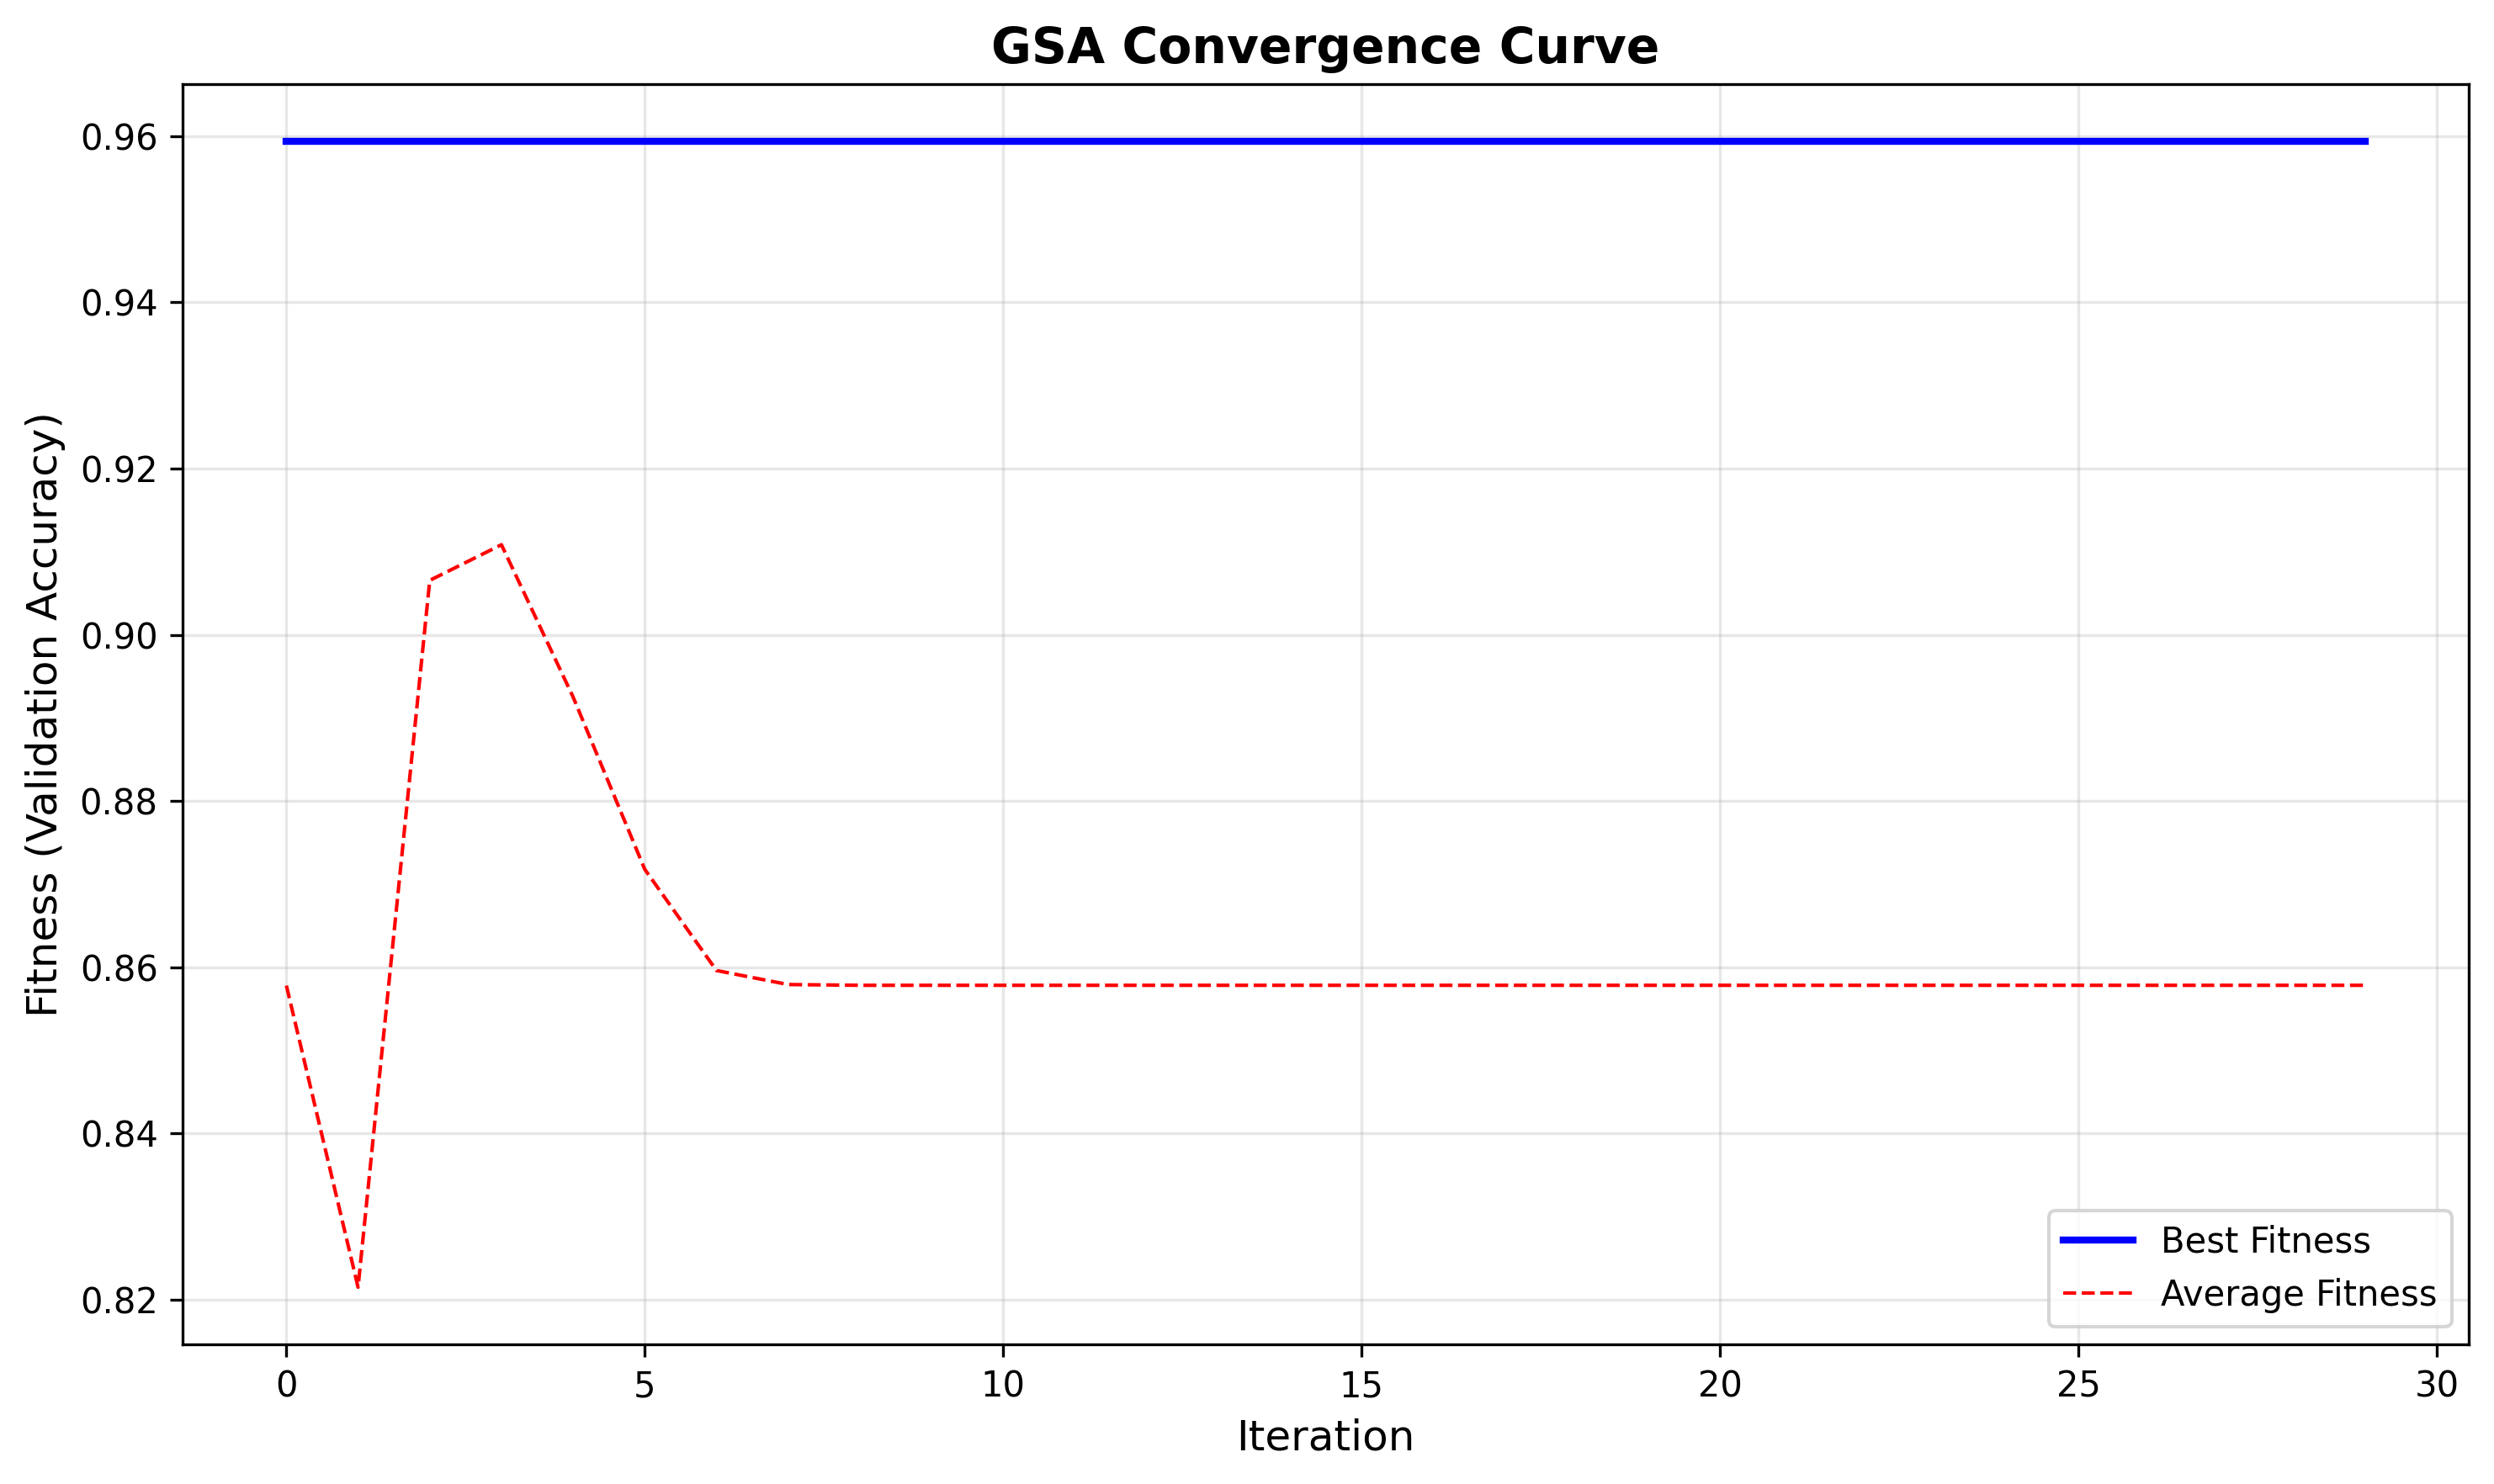


💡 Giải thích:
   - Đường xanh: Fitness tốt nhất (best fitness)
   - Đường đỏ: Fitness trung bình của population
   - Fitness càng cao → bộ features càng tốt


In [8]:
# Hiển thị biểu đồ hội tụ GSA
if gsa_config['enabled']:
    from IPython.display import Image, display
    import matplotlib.pyplot as plt
    
    print("📈 Biểu đồ hội tụ GSA:")
    print("   (Cho thấy fitness tăng dần qua các vòng lặp)\n")
    display(Image(filename=convergence_path))
    
    print(f"\n💡 Giải thích:")
    print(f"   - Đường xanh: Fitness tốt nhất (best fitness)")
    print(f"   - Đường đỏ: Fitness trung bình của population")
    print(f"   - Fitness càng cao → bộ features càng tốt")


In [9]:
# So sánh trước và sau GSA
if gsa_config['enabled']:
    import pandas as pd
    
    comparison = pd.DataFrame({
        'Metric': ['Số đặc trưng', 'Fitness/Accuracy', 'Giảm kích thước'],
        'Trước GSA': [len(X_columns_original), '-', '-'],
        'Sau GSA': [
            len(selected_features),
            f"{gsa.best_fitness:.4f}",
            f"{(1 - len(selected_features)/len(X_columns_original))*100:.1f}%"
        ]
    })
    
    print("\n📊 So sánh Trước/Sau GSA:")
    display(comparison)
    
    print(f"\n✅ Đã giảm {len(X_columns_original) - len(selected_features)} đặc trưng nhiễu!")
else:
    print("\n⏭️  Bỏ qua GSA - sử dụng tất cả features")



📊 So sánh Trước/Sau GSA:


,Metric,Trước GSA,Sau GSA
0,Số đặc trưng,46,22
1,Fitness/Accuracy,-,0.9594
2,Giảm kích thước,-,52.2%



✅ Đã giảm 24 đặc trưng nhiễu!


## 5. Encode Labels

Convert attack class names to numeric labels (0-33).


In [10]:
# Encode labels for BOTH train and test sets
print("="*80)
print("ENCODING LABELS FOR TRAIN AND TEST")
print("="*80)

output_models_dir = '../Output/models'
os.makedirs(output_models_dir, exist_ok=True)

# Encode train labels (fit the encoder)
df_train, label_encoder, label_mapping = data_utils.encode_labels(
    df_train=df_train,
    label_col=y_column,
    save_path=output_models_dir
)

# Encode test labels (transform using the same encoder)
print(f"\n🏷️  Encoding test labels using same encoder...")
df_test[y_column] = label_encoder.transform(df_test[y_column])
print(f"   ✓ Encoded test labels ({len(df_test):,} samples)")

print(f"\n✅ Labels encoded for both train and test sets!")
print(f"\n📋 Label mapping (first 10):")
for i in range(min(10, len(label_mapping))):
    print(f"   {i}: {label_mapping[i]}")
if len(label_mapping) > 10:
    print(f"   ... and {len(label_mapping) - 10} more")

print("="*80)

ENCODING LABELS FOR TRAIN AND TEST

🏷️  Encoding labels...
   Found 34 unique labels:
      DDoS-ICMP_Flood: 323,034 (15.42%)
      DDoS-UDP_Flood: 242,806 (11.59%)
      DDoS-TCP_Flood: 202,511 (9.67%)
      DDoS-PSHACK_Flood: 184,101 (8.79%)
      DDoS-SYN_Flood: 182,237 (8.70%)
      DDoS-RSTFINFlood: 181,338 (8.66%)
      DDoS-SynonymousIP_Flood: 160,956 (7.68%)
      DoS-UDP_Flood: 149,283 (7.13%)
      DoS-TCP_Flood: 119,644 (5.71%)
      DoS-SYN_Flood: 90,263 (4.31%)
      ... and 24 more
   ✓ Encoded 34 classes to numeric values (0-33)
   💾 Saved label encoder to: ../Output/models/label_encoder.pkl
   💾 Saved label mapping to: ../Output/models/labels.json

🏷️  Encoding test labels using same encoder...
   ✓ Encoded test labels (523,670 samples)

✅ Labels encoded for both train and test sets!

📋 Label mapping (first 10):
   0: Backdoor_Malware
   1: BenignTraffic
   2: BrowserHijacking
   3: CommandInjection
   4: DDoS-ACK_Fragmentation
   5: DDoS-HTTP_Flood
   6: DDoS-ICMP_Floo

## 6. Normalize Features

Scale all features to [0, 1] range using MinMaxScaler.


In [11]:
# Normalize features for BOTH train and test sets
print("="*80)
print("NORMALIZING FEATURES FOR TRAIN AND TEST")
print("="*80)

# Normalize train features (fit the scaler)
df_train, scaler = data_utils.normalize_features(
    df_train=df_train,
    feature_cols=X_columns,
    save_path=output_models_dir
)

# Normalize test features (transform using the same scaler)
print(f"\n📏 Normalizing test features using same scaler...")
df_test[X_columns] = scaler.transform(df_test[X_columns])
print(f"   ✓ Normalized test features ({len(df_test):,} samples)")

print(f"\n✅ Features normalized for both train and test sets!")
print(f"\n📊 Sample normalized values (first 5 rows, first 5 features):")
display(df_train[X_columns[:5]].head())

print("="*80)

NORMALIZING FEATURES FOR TRAIN AND TEST

📏 Normalizing features...
   ✓ Normalized 22 features to [0, 1] range
   💾 Saved scaler to: ../Output/models/scaler.pkl

📏 Normalizing test features using same scaler...
   ✓ Normalized test features (523,670 samples)

✅ Features normalized for both train and test sets!

📊 Sample normalized values (first 5 rows, first 5 features):


,Srate,Drate,fin_flag_number,syn_flag_number,psh_flag_number
2041133,1.827777e-05,0.0,0.0,0.0,0.0
1507126,3.768140e-06,0.0,0.0,0.0,0.0
1466681,1.146153e-03,0.0,0.0,0.0,0.0
2348036,2.401681e-03,0.0,0.0,0.0,0.0
470952,6.014885e-08,0.0,0.0,1.0,0.0


## 7. Partition Data for Federated Learning

Split data into:

- 5 client partitions (Non-IID distribution)
- 1 test set (20% of data)


In [12]:
# Partition data for federated learning
print("="*80)
print("PARTITIONING DATA FOR FEDERATED LEARNING")
print("="*80)

# Partition TRAIN data only (test is already separated)
client_data = data_utils.partition_data_noniid(
    df_train=df_train,
    num_clients=config['num_clients'],
    label_col=y_column,
    test_split=None,  # Not used anymore
    random_seed=config['random_seed']
)

# Add test set separately
print(f"\n📊 Adding test set...")
X_test = df_test.drop(columns=[y_column]).values
y_test = df_test[y_column].values
client_data['test'] = {
    'X': X_test,
    'y': y_test
}
print(f"   Test set: {len(X_test):,} samples")

print(f"\n✅ Data partitioned successfully!")
print(f"\n📊 Final partition summary:")
for client_name, data in client_data.items():
    print(f"   {client_name}: {len(data['X']):,} samples")

# Verify train/test split ratio
total_train = sum(len(data['X']) for name, data in client_data.items() if name != 'test')
total_test = len(client_data['test']['X'])
total_all = total_train + total_test
actual_test_ratio = (total_test / total_all) * 100

print(f"\n📊 Train/Test Split Verification:")
print(f"   Total samples: {total_all:,}")
print(f"   Train samples: {total_train:,} ({(total_train/total_all)*100:.2f}%)")
print(f"   Test samples: {total_test:,} ({actual_test_ratio:.2f}%)")
print(f"   Expected test ratio: {config['data']['test_split_ratio']*100:.1f}%")

if abs(actual_test_ratio - (config['data']['test_split_ratio']*100)) < 1.0:
    print(f"   ✅ Split ratio is correct!")
else:
    print(f"   ⚠️  Note: Actual ratio differs due to data cleaning steps")

print("="*80)

PARTITIONING DATA FOR FEDERATED LEARNING

🔀 Partitioning data for 5 clients (Non-IID)...


   Total training samples: 2,094,678
   Found 34 unique labels in training data

   Label distribution (showing labels with < 100 samples):
      Label 28: 89 samples
      Label 31: 64 samples

   ✅ All 34 labels are covered in attack groups
   Client 0 (DDoS): 1,067,712 samples from labels [4, 5, 6, 7, 8]...
   Client 1 (DoS): 71,553 samples from labels [16, 17, 18, 19]
   Client 2 (Mirai): 197,913 samples from labels [20, 21, 22]
   Client 3 (Recon): 89,883 samples from labels [23, 24, 25, 26, 27]
   Client 4 (Others): 39,212 samples from labels [0, 1, 2, 3, 28]...

   Distributing 628,405 remaining samples across all clients...
      → Client 0 gets +125,681 samples
      → Client 1 gets +125,681 samples
      → Client 2 gets +125,681 samples
      → Client 3 gets +125,681 samples
      → Client 4 gets +125,681 samples

   📊 Final distribution:
      Client 0: 1,193,393 samples (57.0%)
      Client 1: 197,234 samples (9.4%)
      Client 2: 323,594 samples (15.4%)
      Client 3: 21

### 7.1 Visualize Client Data Distribution


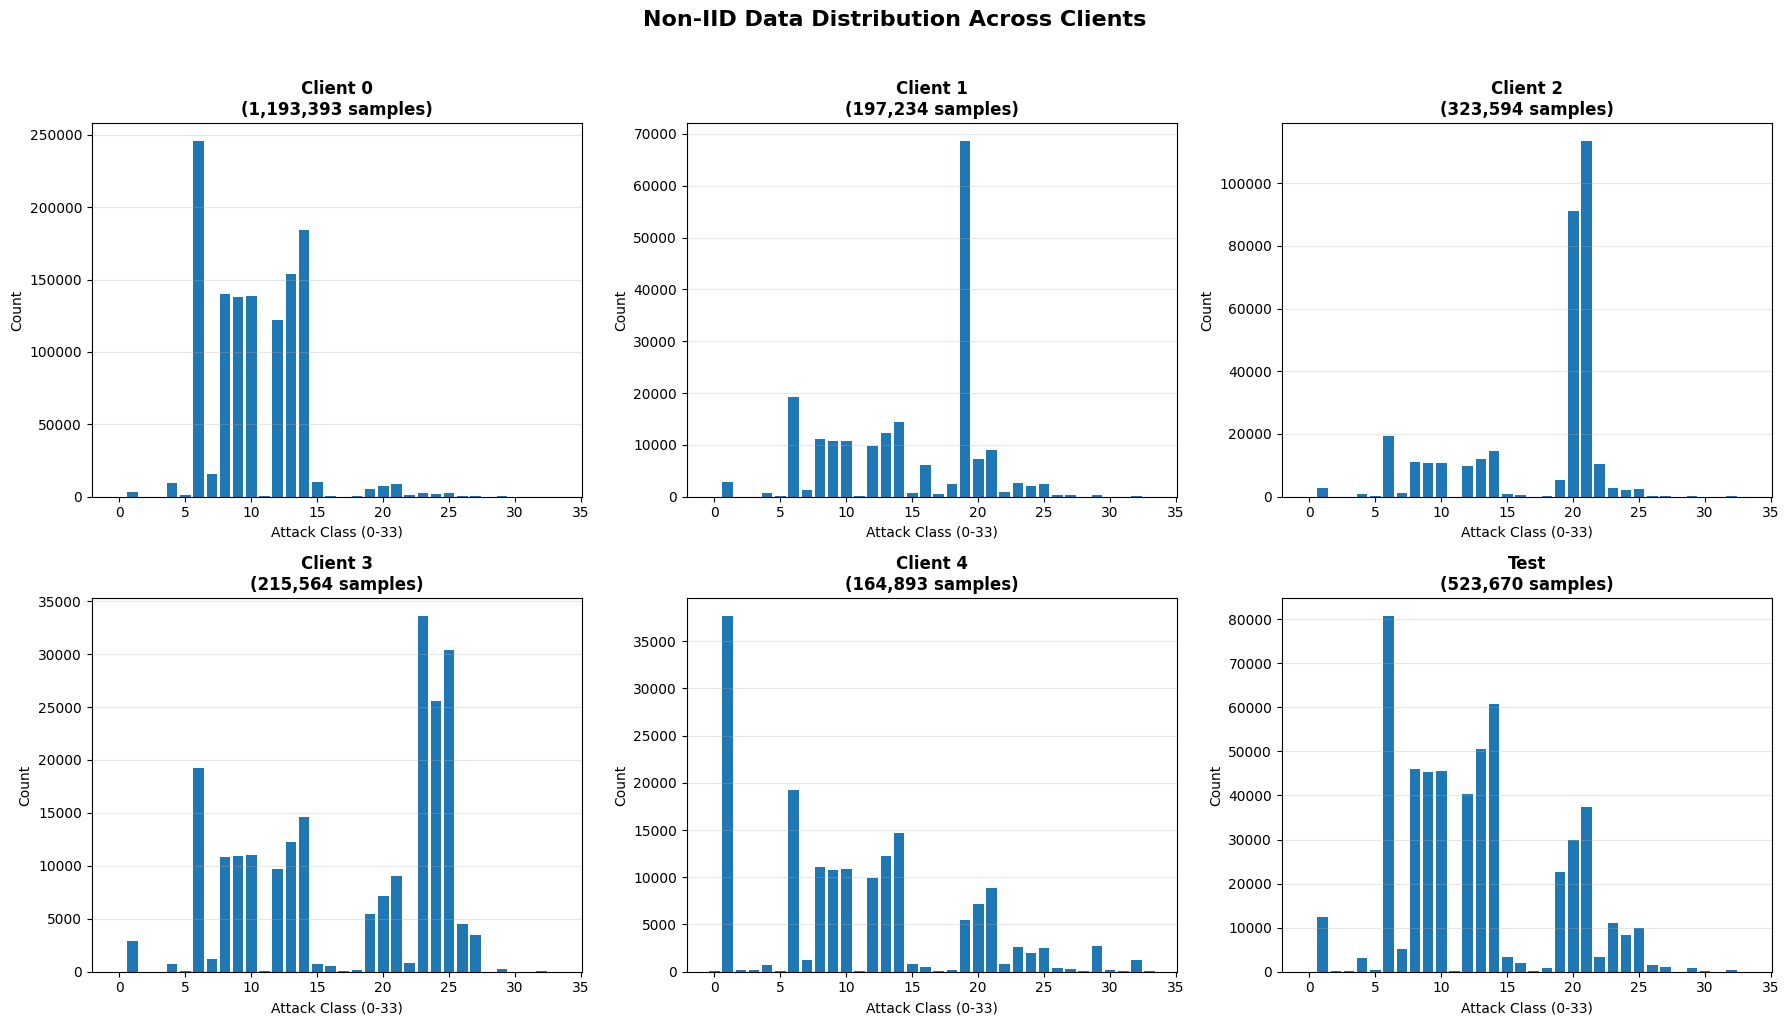


📊 Distribution analysis:
   Each client has a different distribution of attack types (Non-IID)
   This simulates real-world federated learning scenarios.


In [13]:
# Visualize label distribution per client
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (client_name, data) in enumerate(client_data.items()):
    if i >= 6:  # Only plot first 6 (5 clients + test)
        break
    
    # Count labels
    unique, counts = np.unique(data['y'], return_counts=True)
    
    # Plot
    axes[i].bar(unique, counts)
    axes[i].set_title(f'{client_name.replace("_", " ").title()}\n({len(data["X"]):,} samples)', 
                     fontweight='bold')
    axes[i].set_xlabel('Attack Class (0-33)')
    axes[i].set_ylabel('Count')
    axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Non-IID Data Distribution Across Clients', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Distribution analysis:")
print("   Each client has a different distribution of attack types (Non-IID)")
print("   This simulates real-world federated learning scenarios.")

In [20]:
# Verify stratified split: Check label distribution in train vs test
print("="*80)
print("VERIFICATION: Stratified Train/Test Split")
print("="*80)

# Get all train data (combine all clients)
train_labels = []
for client_name, data in client_data.items():
    if client_name != 'test':
        train_labels.extend(data['y'].tolist())

test_labels = client_data['test']['y'].tolist()

# Count labels in train and test
train_label_counts = pd.Series(train_labels).value_counts().sort_index()
test_label_counts = pd.Series(test_labels).value_counts().sort_index()

# Calculate proportions
train_total = len(train_labels)
test_total = len(test_labels)

print(f"\n📊 Label Distribution Verification (34 labels):")
print(f"   Train set: {train_total:,} samples")
print(f"   Test set: {test_total:,} samples")
print(f"   Expected test ratio: {config['data']['test_split_ratio']*100:.1f}%")
print(f"   Actual test ratio: {test_total/(train_total+test_total)*100:.2f}%")

print(f"\n📋 Label Proportions (showing all 34 labels):")
print(f"{'Label':<5} {'Train Count':<15} {'Train %':<12} {'Test Count':<15} {'Test %':<12} {'Train/Test Split':<20} {'Match':<8}")
print("-" * 95)

for label in sorted(set(train_label_counts.index) | set(test_label_counts.index)):
    train_count = train_label_counts.get(label, 0)
    test_count = test_label_counts.get(label, 0)
    train_pct = (train_count / train_total * 100) if train_total > 0 else 0
    test_pct = (test_count / test_total * 100) if test_total > 0 else 0
    
    # Calculate actual split ratio for THIS label (what % of this label went to test)
    total_label_count = train_count + test_count
    if total_label_count > 0:
        label_test_ratio = (test_count / total_label_count) * 100
        label_train_ratio = (train_count / total_label_count) * 100
        split_display = f"{label_train_ratio:.1f}% / {label_test_ratio:.1f}%"
    else:
        label_test_ratio = 0
        split_display = "N/A"
    
    # Check if this label's split ratio matches the expected 80/20 (±1% tolerance on test)
    expected_test_ratio = config['data']['test_split_ratio'] * 100
    ratio_match = "✓" if abs(label_test_ratio - expected_test_ratio) < 1.0 else "⚠"
    
    print(f"{label:<5} {train_count:<15,} {train_pct:<11.2f}% {test_count:<15,} {test_pct:<11.2f}% {split_display:<20} {ratio_match:<8}")

# Check if all 34 labels are present in both train and test
all_labels_train = set(train_label_counts.index)
all_labels_test = set(test_label_counts.index)
all_labels = all_labels_train | all_labels_test

print(f"\n✅ Label Coverage:")
print(f"   Total unique labels: {len(all_labels)}")
print(f"   Labels in train: {len(all_labels_train)}")
print(f"   Labels in test: {len(all_labels_test)}")
print(f"   All labels present in both sets: {'✓ YES' if all_labels_train == all_labels_test == all_labels else '✗ NO'}")

# Verify stratification: each label should have ~20% in test
print(f"\n🔍 Stratification Check:")
stratified_correctly = True
for label in all_labels:
    train_count = train_label_counts.get(label, 0)
    test_count = test_label_counts.get(label, 0)
    total_count = train_count + test_count
    if total_count > 0:
        actual_test_ratio = test_count / total_count
        expected_test_ratio = config['data']['test_split_ratio']
        # Allow 1% tolerance
        if abs(actual_test_ratio - expected_test_ratio) > 0.01:
            stratified_correctly = False
            print(f"   ⚠️  Label {label}: Expected {expected_test_ratio*100:.1f}% in test, got {actual_test_ratio*100:.2f}%")
            break

if stratified_correctly:
    print(f"   ✅ All labels maintain ~{config['data']['test_split_ratio']*100:.0f}% ratio in test set (stratified correctly)")

print("="*80)

VERIFICATION: Stratified Train/Test Split

📊 Label Distribution Verification (34 labels):
   Train set: 2,094,678 samples
   Test set: 523,670 samples
   Expected test ratio: 20.0%
   Actual test ratio: 20.00%

📋 Label Proportions (showing all 34 labels):
Label Train Count     Train %      Test Count      Test %       Train/Test Split     Match   
-----------------------------------------------------------------------------------------------
0     152             0.01       % 38              0.01       % 80.0% / 20.0%        ✓       
1     49,481          2.36       % 12,370          2.36       % 80.0% / 20.0%        ✓       
2     258             0.01       % 64              0.01       % 80.1% / 19.9%        ✓       
3     225             0.01       % 56              0.01       % 80.1% / 19.9%        ✓       
4     12,800          0.61       % 3,200           0.61       % 80.0% / 20.0%        ✓       
5     1,279           0.06       % 320             0.06       % 80.0% / 20.0%       

## 8. Save Partitioned Data


In [15]:
# Save partitioned data
output_data_dir = '../Output/data'

data_utils.save_partitioned_data(
    client_data=client_data,
    save_dir=output_data_dir
)

print(f"\n✅ All data saved successfully!")


💾 Saving partitioned data to: ../Output/data
   ✓ Saved client_0: ../Output/data/client_0_data.npz (1,193,393 samples)
   ✓ Saved client_1: ../Output/data/client_1_data.npz (197,234 samples)
   ✓ Saved client_2: ../Output/data/client_2_data.npz (323,594 samples)
   ✓ Saved client_3: ../Output/data/client_3_data.npz (215,564 samples)
   ✓ Saved client_4: ../Output/data/client_4_data.npz (164,893 samples)
   ✓ Saved test: ../Output/data/test_data.npz (523,670 samples)
   ✅ All data saved successfully!

✅ All data saved successfully!


## 9. Verification

Verify that all files were created correctly.


In [16]:
# Check saved files
print("🔍 Verifying saved files...\n")

# Check data files
print("📂 Data files:")
for client_name in list(client_data.keys()):
    file_path = os.path.join(output_data_dir, f'{client_name}_data.npz')
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024**2  # MB
        print(f"   ✓ {client_name}_data.npz ({file_size:.2f} MB)")
    else:
        print(f"   ✗ {client_name}_data.npz (NOT FOUND)")

# Check model artifacts
print("\n📂 Model artifacts:")
artifacts = ['scaler.pkl', 'label_encoder.pkl', 'labels.json']
for artifact in artifacts:
    file_path = os.path.join(output_models_dir, artifact)
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"   ✓ {artifact} ({file_size:.2f} KB)")
    else:
        print(f"   ✗ {artifact} (NOT FOUND)")

print("\n✅ Verification complete!")

🔍 Verifying saved files...

📂 Data files:
   ✓ client_0_data.npz (34.44 MB)
   ✓ client_1_data.npz (6.76 MB)
   ✓ client_2_data.npz (10.71 MB)
   ✓ client_3_data.npz (7.72 MB)
   ✓ client_4_data.npz (6.66 MB)
   ✓ test_data.npz (14.76 MB)

📂 Model artifacts:
   ✓ scaler.pkl (1.64 KB)
   ✓ label_encoder.pkl (0.85 KB)
   ✓ labels.json (0.91 KB)

✅ Verification complete!


## 10. Summary

Data preprocessing completed successfully!


In [17]:
print("="*80)
print("DATA PREPROCESSING SUMMARY")
print("="*80)
print(f"\n📊 Dataset Statistics:")
print(f"   Total samples processed: {sum(len(data['X']) for data in client_data.values()):,}")
print(f"   Number of features: {len(X_columns)}")
print(f"   Number of classes: {len(label_mapping)}")

print(f"\n🔀 Data Partitioning:")
print(f"   Number of clients: {config['num_clients']}")
print(f"   Partition strategy: {config['data']['partition_strategy'].upper()}")
print(f"   Test set size: {len(client_data['test']['X']):,} samples ({config['data']['test_split_ratio']*100}%)")

print(f"\n💾 Output Files:")
print(f"   Data files: {config['num_clients'] + 1} .npz files (5 clients + 1 test)")
print(f"   Model artifacts: 3 files (scaler, encoder, labels)")


DATA PREPROCESSING SUMMARY

📊 Dataset Statistics:
   Total samples processed: 2,618,348
   Number of features: 22
   Number of classes: 34

🔀 Data Partitioning:
   Number of clients: 5
   Partition strategy: NON_IID
   Test set size: 523,670 samples (20.0%)

💾 Output Files:
   Data files: 6 .npz files (5 clients + 1 test)
   Model artifacts: 3 files (scaler, encoder, labels)
